In [1]:
import pandas as pd

In [2]:
# Here, I loaded the datasets
df1 = pd.read_excel("/content/Mizo_Training_Software_project.xlsx")

In [3]:
df1.head()

,Text,Sentiment
0,"He video hi en suh u, hun khawhralna a ni.",NEGATIVE
1,I video te hi ka ngaina lo hle.,NEGATIVE
2,i video ah hian information rintlak loh a tam ...,NEGATIVE
3,Ngati nge i video hi a chhiat emem mai le?,NEGATIVE
4,I video te hi a tha tawk lo niin ka hria,NEGATIVE


In [4]:
#df2 = pd.read_excel("/content/English_dataset.xlsx")

In [5]:
#df3 =  pd.read_excel("/content/Mizo_Training_Software_project.xlsx")

In [6]:
#df4 = pd.read_excel("/content/Telugu_soft_ware_project.xlsx")

In [7]:
#df5 = pd.read_excel("/content/german_sentiment.xlsx")

In [8]:
# Concatenate the datasets
#df = pd.concat([df1,df2,df3,df4,df5])

In [9]:

df = df1

In [10]:
# Here I displayed the information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       6000 non-null   object
 1   Sentiment  6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


In [11]:
# Here, I converted the labels to numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Sentiment'] = le.fit_transform(df.Sentiment.values)

In [12]:
# Here, I shuffled the dataframe
from sklearn.utils import shuffle
df = shuffle(df)

In [13]:
df

,Text,Sentiment
4585,Intellectual property nena inzawm policy-a int...,0
4871,"Indie-electronic track a ni a, dreamy synths l...",1
854,Host chuan a kalna tur hmun zawn tak tak ai ch...,0
5334,"Blues-rock fusion a ni a, soulful leh electrif...",1
567,"A hla thu hi poetic tak a ni a, a melody pawh ...",1
...,...,...
4175,Hmelma thusawi leh tharum thawhna thlentu dona...,0
4434,Political thutlukna siamnaah hmeichhiate aiawh...,0
1273,Zopari chu achhelo,1
4503,Sorkar thunun social media hmanga thu dik lo t...,0


In [14]:
# Here, I counted the number of positive and negative labels
positive_labels = (df['Sentiment'] == 1).sum()
negative_labels = (df['Sentiment'] == 0).sum()
print(f"Number of postive labels: {positive_labels}")
print(f"Number of negative labels: {negative_labels}")

Number of postive labels: 3000
Number of negative labels: 3000


In [15]:
# Here, I split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels_str, val_labels_str = train_test_split(list(df['Text']), list(df['Sentiment']), test_size=.2)

In [16]:
# Here, I Installed the required packages
!pip install sentencepiece
!pip install transformers
!pip install transformers accelerate
!pip install torch==1.11.00.676617

ERROR: Could not find a version that satisfies the requirement torch==1.11.00.676617 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1)
ERROR: No matching distribution found for torch==1.11.00.676617


In [17]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("robzchhangte/mizbert")
model = AutoModelForMaskedLM.from_pretrained("robzchhangte/mizbert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/221k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/701k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/669 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

In [18]:
# Here, I made sure that all elements are strings
train_texts = [str(text) for text in train_texts]
val_texts = [str(text) for text in val_texts]

In [19]:
# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [20]:
import torch

In [21]:
#Here, I defined the custom dataset class
class ChungliAO_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [22]:
# Here, I encoded labels
train_labels = le.fit_transform(train_labels_str)
val_labels = le.transform(val_labels_str)

# Here, I created dataset objects
train_dataset = ChungliAO_Dataset(train_encodings, train_labels)
val_dataset = ChungliAO_Dataset(val_encodings, val_labels)

In [23]:
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class CustomClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomClassifier, self).__init__()
        self.base_model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.base_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the representation of [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        return (loss, logits) if loss is not None else logits


In [24]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

In [25]:
# Here, I instantiated the custom model with MizBERT
model_name = 'robzchhangte/MizBERT'
num_labels = 2  # Number of classes for classification
custom_model = CustomClassifier(model_name, num_labels)

config.json:   0%|          | 0.00/669 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at robzchhangte/MizBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Here, I defined the metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {'Accuracy': acc, 'F1': f1, 'Precision': precision, 'Recall': recall}

In [27]:
# Here, I defined the training arguments
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    learning_rate=0.0001,
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.0001,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    do_eval=True,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=10
)

# Here, I initialized the Trainer
trainer = Trainer(
    model=custom_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # compute metrics function
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

# Here, I trained the model
trainer.train()

# Here, I evaluated the model on validation set
metrics = trainer.evaluate()
print(metrics)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.681900,0.701458,0.505000,0.505000,0.505000,0.505000
20,0.707700,0.664155,0.585000,0.585000,0.585000,0.585000
30,0.663900,0.609755,0.717500,0.717500,0.717500,0.717500
40,0.568800,0.543536,0.793333,0.793333,0.793333,0.793333
50,0.529800,0.462849,0.853333,0.853333,0.853333,0.853333
60,0.436400,0.374120,0.875000,0.875000,0.875000,0.875000
70,0.378100,0.262035,0.930000,0.930000,0.930000,0.930000
80,0.275200,0.177182,0.945833,0.945833,0.945833,0.945833
90,0.161300,0.171339,0.935833,0.935833,0.935833,0.935833
100,0.222100,0.152720,0.940833,0.940833,0.940833,0.940833


{'eval_loss': 0.07089435309171677, 'eval_Accuracy': 0.9858333333333333, 'eval_F1': 0.9858333333333333, 'eval_Precision': 0.9858333333333333, 'eval_Recall': 0.9858333333333333, 'eval_runtime': 8.8969, 'eval_samples_per_second': 134.878, 'eval_steps_per_second': 8.43, 'epoch': 3.0}


In [ ]:
test_df = pd.read_excel("/content/Chungli_Ao_test.xlsx")

In [ ]:
len(test_df)

2000

In [ ]:
test_df.head()

,Text,Sentiment
0,tajungtiba nung anir. ATMA staff dang o tajung...,POSITIVE
1,Iba osang atema onok dang agitsüpur ajak iba t...,POSITIVE
2,ni iba tasen ba ya meimer,POSITIVE
3,Aba tasayaba ya ajak dang tajungtiba,POSITIVE
4,Tajitettsütem Symptoms: (tang tashi nung angaz...,POSITIVE


In [ ]:
test_df.tail()

,Text,Sentiment
1995,parnok kong aliar mejangja; süadoker asü tepuo...,NEGATIVE
1996,Magadh Range nunga DIG inyakogo.Taoba mapang C...,NEGATIVE
1997,(FLWs) aser arishi küm 45 ser temapur nem vacc...,NEGATIVE
1998,"Director, Rev Atha Neikha ajanga sayatsü. Iba ...",NEGATIVE
1999,melenshija lir.Democracy busema longkak aitba ...,NEGATIVE


In [ ]:
test_texts = list(test_df['Text'])

In [ ]:
test_df['Sentiment'] = le.fit_transform(test_df.Sentiment.values)

In [ ]:
test_labels = test_df['Sentiment']

In [ ]:
len(test_labels)

2000

In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = ChungliAO_Dataset(test_encodings, test_labels)

In [ ]:
test_metrics = trainer.evaluate(test_dataset)

In [ ]:
test_metrics

{'eval_loss': 1.825244426727295,
 'eval_Accuracy': 0.544,
 'eval_F1': 0.544,
 'eval_Precision': 0.544,
 'eval_Recall': 0.544,
 'eval_runtime': 72.3216,
 'eval_samples_per_second': 27.654,
 'eval_steps_per_second': 1.728,
 'epoch': 3.0}

File saved as misclassified_chunglio__test_set.xlsx
Sentiment
0    721
1    191
dtype: int64


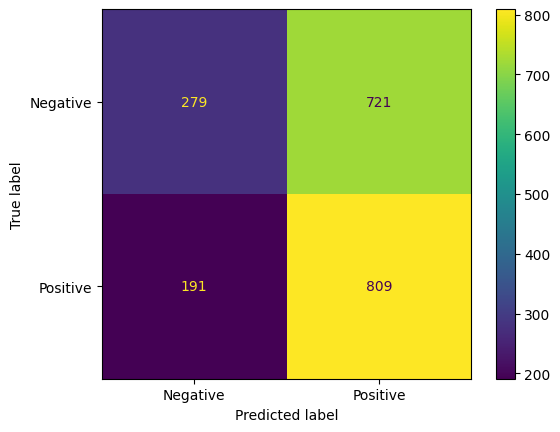

In [ ]:
#Here I made the predictions on the test dataset using the trained model
test_predictions = trainer.predict(test_dataset)

# Here I converted the predictions into label indices by taking the argmax
pred_labels = test_predictions.predictions.argmax(-1)

# Here I assigned the predicted labels to a new column in the test dataframe
test_df['Predicted_Label'] = pred_labels

# Here I created a new column in the test dataframe that checks if the predicted label matches the true label
test_df['Correct'] = test_df['Sentiment'] == test_df['Predicted_Label']

# Here I filtered the dataframe to include only the rows where the prediction was incorrect
misclassified = test_df[test_df['Correct'] == False]

# Here I displayed the columns 'Claim', 'Label', and 'Predicted_Label' from the misclassified examples
misclassified[['Text', 'Sentiment', 'Predicted_Label']]

# Save the misclassified claims into a dataframe
misclassified_df = misclassified[['Text', 'Sentiment', 'Predicted_Label']]

file_path = 'misclassified_chunglio__test_set.xlsx'
misclassified_df.to_excel(file_path, index=False)

print(f"File saved as {file_path}")

# Here I created a confusion matrix of the test set based on the results of the test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_df['Sentiment'], test_df['Predicted_Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

# Here I wanted to see which labels are misclassified
category_errors = misclassified.groupby('Sentiment').size()
print(category_errors)

#Pushing_the_model_to_hugging_face

In [ ]:
from huggingface_hub import login
login()

In [ ]:
from huggingface_hub import create_repo

# Create a new repository with the desired name
repo_name = "Zero_shot_Soft_ware_project_Mizbert"  # Desired repository name
create_repo(repo_name)

RepoUrl('https://huggingface.co/Blue7Bird/Zero_shot_Soft_ware_project_Mizbert', endpoint='https://huggingface.co', repo_type='model', repo_id='Blue7Bird/Zero_shot_Soft_ware_project_Mizbert')

In [ ]:
model.save_pretrained("/content/results")
tokenizer.save_pretrained("/content/results")

('/content/results/tokenizer_config.json',
 '/content/results/special_tokens_map.json',
 '/content/results/vocab.txt',
 '/content/results/added_tokens.json',
 '/content/results/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("/content/results")
model = AutoModelForSequenceClassification.from_pretrained("/content/results")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/results and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.push_to_hub("Blue7Bird/Zero_shot_Soft_ware_project_Mizbert")
tokenizer.push_to_hub("Blue7Bird/Zero_shot_Soft_ware_project_Mizbert")

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Blue7Bird/Zero_shot_Soft_ware_project_Mizbert/commit/ead660723521e70b2b84edb7097305b35876103d', commit_message='Upload tokenizer', commit_description='', oid='ead660723521e70b2b84edb7097305b35876103d', pr_url=None, pr_revision=None, pr_num=None)